In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from functools import reduce

from scipy.interpolate import griddata
import matplotlib.colors as colors

import numpy as np
import DataPreprocessing
import SmartPolynomials
import SplitDataSet

Using TensorFlow backend.


In [2]:
def transform(me):
    return np.multiply(np.sign(me), np.power(abs(me), 1.))
def inverse(temp):
    return np.multiply(np.sign(temp),np.power(abs(temp), 1.))
def inverse_tf(temp):
    return tf.multiply(tf.sign(temp),tf.pow(tf.abs(temp), 1.)) 
def frac_error(true, experimental):
    return np.abs(np.divide(inverse(true) - inverse(experimental), inverse(true)))

In [3]:
def perc_error(true, experimental):
    return 100*tf.abs(tf.divide(inverse_tf(true) - inverse_tf(experimental), inverse_tf(true)))

def build_model(components=150, momentum=0.9, learning_rate=0.0002, activation='elu', hidden_layers=1):
    #activation = keras.
    model = keras.Sequential([
        keras.layers.Dense(components, activation=activation, input_shape=[8],
                          kernel_regularizer=keras.regularizers.l2(0.0001)), #could try swish??  

        keras.layers.Dense(components + 150, activation=activation,
                          kernel_regularizer=keras.regularizers.l2(0.0001)),
        keras.layers.Dense(components + 2, activation=activation,
                          kernel_regularizer=keras.regularizers.l2(0.0001)),

        keras.layers.Dense(1, activation='linear') 
    ])

    adam = tf.keras.optimizers.Adam(0.005)
    model.compile(loss='mse', 
                optimizer=adam, metrics=['mape',perc_error])
    return model

In [4]:
def calc_RMSE(mom_train, mom_test, rescaled_train, rescaled_test, reuse_model=False):
    if reuse_model:
        model = build_model()
        model.load_weights("NLO/MODEL/uuxg.hdf5")
    else:
        model = build_model()
    
    temp_train = rescaled_train[:,1]/rescaled_train[:,0]
    temp_test = rescaled_test[:,1]/rescaled_test[:,0]
    
    scaler = StandardScaler()

    poly_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train[:,1:]])
    poly_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test[:,1:]])
    poly_train = scaler.fit_transform(poly_train) #Rescale on training set
    poly_test = scaler.transform(poly_test)


    # Callback for printing the LR at the end of each epoch.
    class PrintLR(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if epoch % 10 == 0:
                temp_predict = self.model.predict(poly_test)
                temp_predict.shape = (len(temp_predict))
                error = 100*np.mean(born_error(temp_test, temp_predict, rescaled_test[:,0]))
                print('\nPercentage error : {}'.format(error))
    
        # Saves the best model's weights
    checkpoint_path = "NLO/MODEL/uuxg.hdf5"
    callback_a = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=True)
    callback_b = tf.keras.callbacks.EarlyStopping(monitor='val_perc_error', patience=30)
    history = model.fit(poly_train, temp_train, batch_size=256, epochs=1000, 
                        shuffle=True, verbose=1, callbacks=[callback_b, callback_a],
                       validation_data=(poly_test, temp_test))


    try:
        # load the saved model
        saved_model = build_model()
        saved_model.load_weights(checkpoint_path)
        
        train_predict = saved_model.predict(poly_train)
        train_predict.shape = (len(train_predict))     
        train_error = 100*np.mean(frac_error(temp_train, train_predict))                                 
        
        test_predict = saved_model.predict(poly_test)
        test_predict.shape = (len(test_predict))
        test_error = 100*np.mean(frac_error(temp_test, test_predict))

        print('Train: %.3f, Test: %.3f' % (train_error, test_error))
        
        #return(train_error, test_error, born_error(temp_test, test_predict, rescaled_test[:,0]), history)
        return(train_error, test_error, temp_test**2 - test_predict**2, history)
    except ValueError:
        print('Value Error Encountered')       
    return(0, 0, 0, 0)

In [5]:
##Obtain & process data NPY
me_train, mom_train = SplitDataSet.smallestS('NLO/MG_uuxg/me_4000000.npy', 'NLO/MG_uuxg/mom_4000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('NLO/MG_uuxg/me_1000000.npy', 'NLO/MG_uuxg/mom_1000000.npy', 1)

print(me_train.shape)
div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3','1,2'], mom_train))
div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3','1,2'], mom_test))
    
temp_train = np.multiply(div_train[:,np.newaxis], me_train)
temp_test = np.multiply(div_test[:,np.newaxis], me_test)


#div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,2'], mom_train))
#div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,2'], mom_test))
    
#temp_train = np.multiply(div_train[:,np.newaxis], temp_train)
#temp_test = np.multiply(div_test[:,np.newaxis], temp_test)

#temp_train = transform(temp_train)
#temp_test = transform(temp_test)

(1334014, 4)


In [6]:
print('Std : {}'.format(np.std(temp_train[:,1])))
print('Mean : {}'.format(np.mean(temp_train[:,1])))

train, test, perc, history = calc_RMSE(mom_train, mom_test, temp_train, temp_test, reuse_model=False)

Std : 15914203123.29427
Mean : -4515464973.103091
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 1334014 samples, validate on 332820 samples
Epoch 1/1000
1334014/1334014 [==============================]1334014/1334014 [==============================] - 26s 19us/step - loss: 0.0415 - mean_absolute_percentage_error: 184.4234 - perc_error: 184.4234 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 129.4987 - val_perc_error: 129.4987

Epoch 2/1000
1334014/1334014 [==============================]1334014/1334014 [==============================] - 26s 19us/step - loss: 0.0143 - mean_absolute_percentage_error: 124.0053 - perc_error: 124.0053 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 72.6548 - val_perc_error: 72.6548

Epoch 3/1000
1334014/1334014 [==============================]1334014/1334014 [==============================] - 25s 19us/step - loss: 0.0058 - mean_abs


Epoch 26/1000
1334014/1334014 [==============================]1334014/1334014 [==============================] - 25s 19us/step - loss: 0.0044 - mean_absolute_percentage_error: 77.0164 - perc_error: 77.0164 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 53.7277 - val_perc_error: 53.7277

Epoch 27/1000
1334014/1334014 [==============================]1334014/1334014 [==============================] - 25s 19us/step - loss: 0.0374 - mean_absolute_percentage_error: 171.8142 - perc_error: 171.8142 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 53.7896 - val_perc_error: 53.7896

Epoch 28/1000
1334014/1334014 [==============================]1334014/1334014 [==============================] - 25s 19us/step - loss: 0.0066 - mean_absolute_percentage_error: 93.8971 - perc_error: 93.8971 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 71.1055 - val_perc_error: 71.1055

Epoch 29/1000
1334014/1334014 [==============================]1334014/1334014 [========================

In [23]:
print(sum([1 for x in me_test[:,1] if x < 0]))
print(np.argmin(me_test[:,1]))
print(me_test[249761])
print(min(np.array([x + y for x, y in me_test[:,[0,1]]])))

141081
249761
[ 0.80199089 -4.16638045 -0.62646894 -0.06295224]
-3.364389557577856


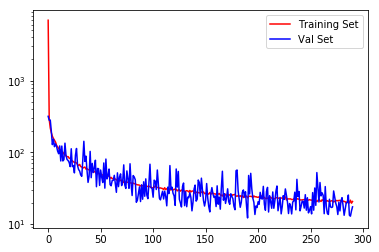

In [6]:
points = len(history.history['loss'])
pyplot.plot(range(points), history.history['loss'], color='r', label='Training Set')
pyplot.plot(range(points), history.history['val_loss'],color='b', label='Val Set')
pyplot.legend()
#pyplot.ylim(0, 18)
pyplot.yscale('log')

2 Layers 500 components min ~ 0.05 mse and 10% error.
Reduced layers by 1 and added 500 components. 

In [7]:
print(train)
print(test)
print(100*np.mean(perc))

2.0909617689350886
1.9846250588931518
1.9846250588931518


In [38]:
saved_model = build_model()
saved_model.load_weights("NLO/MODEL/uuxg.hdf5")

print(np.array(saved_model.get_weights()[6]))

[[-0.05351681 -5.953495   -0.13209592 ... -8.2189865  -1.5712517
   0.22013439]
 [ 0.42662022 -0.63015723 -0.06085935 ... -0.58706415 -0.22059889
  -1.1103675 ]
 [-0.29674727 -0.77685636  0.0556257  ... -1.9459263  -0.59830093
   0.05421333]
 ...
 [-0.29320687  0.75926495 -0.16174175 ...  0.21619107 -0.23981778
  -0.81820714]
 [-0.41860014 -0.99467915 -0.21267658 ... -2.403095   -0.52651376
   0.2199572 ]
 [-1.3106755   0.01778066 -0.3236882  ...  0.15658653  0.20865591
   0.48690158]]


###### print(me_predict)

###### 60% error for temp
Scaled by log 0.04469647411690197

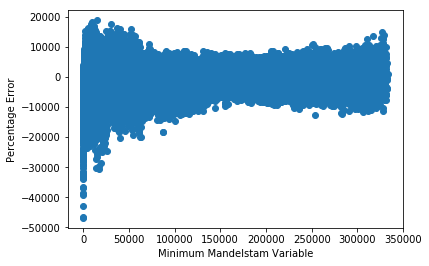

In [12]:
mandel_str = ['1,3','2,3','1,2']
def error_smallest_S(perc_error, mom):
    mandel_vars = DataPreprocessing.mandel_creation(mandel_str, mom)
    min_mandel_vars = [min(mandel_var) for mandel_var in mandel_vars.T]
    #print(sum([1 for i, mandel_var in enumerate(min_mandel_vars) if mandel_var > 175000]))
    #print(100*np.mean([perc_error[i] for i, mandel_var in enumerate(min_mandel_vars) if mandel_var > 100]))
    pyplot.scatter(min_mandel_vars,perc_error)
    pyplot.xlabel('Minimum Mandelstam Variable')
    pyplot.ylabel('Percentage Error')
    #pyplot.xlim(0,1000000)
    
error_smallest_S(perc, mom_test)

In [8]:
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,3','2,3'], mom_test)

x1 = np.divide(s12, 1000000)
x2 = np.divide(s13, 1000000)
x3 = np.divide(s23, 1000000)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [9]:
#Value at grid coordinate is mapped to the nearest actual datapoint.
print(len(perc))
grid = griddata((x2, x3), np.abs(perc), (X2i, X3i), method='linear')
print(grid)

332820
[[          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan 3904.95046519           nan ...           nan
            nan           nan]
 ...
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]]


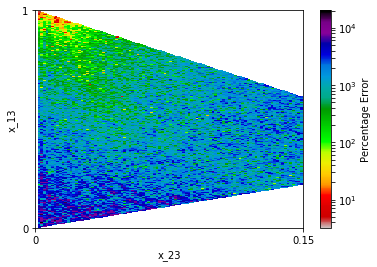

In [10]:
fig, ax = pyplot.subplots()
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
cbar.set_label('Percentage Error')

ax.set_xticks([0, 100])
ax.set_xticklabels([0, 0.15])
ax.set_xlim(0,100)
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('x_13')
ax.set_xlabel('x_23')

pyplot.savefig('PercentageError.png')